In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [8]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/DSL/RegularSession/DimensionalityReduction/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


In [9]:
fashion.shape

(60000, 785)

- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [17]:
fashion= fashion.sample(frac=1).reset_index(drop=True)
labels = fashion['label']
pixels= fashion.iloc[:,1:]

train_len= int(0.8*fashion.shape[0])
X_train, y_train = pixels.iloc[:train_len],pd.DataFrame(labels.iloc[:train_len])
X_test, y_test =pixels.iloc[train_len:], pd.DataFrame(labels.iloc[train_len:])


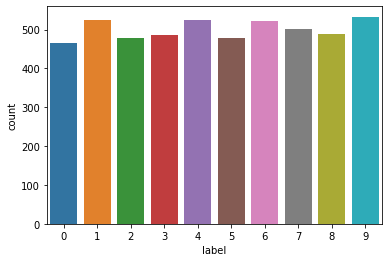

In [24]:
X_train=X_train.loc[:4999,:]
y_train=y_train[:5000]
sns.countplot(x='label',data=y_train)

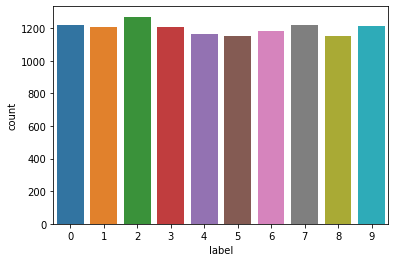

In [22]:
sns.countplot(x='label',data=y_test)

- 어떻게 생긴 데이터셋인지 확인해보기

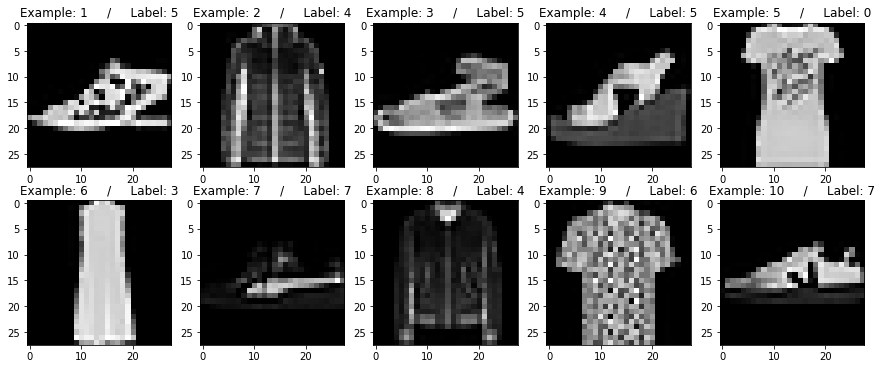

In [23]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [25]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784) #784차원의 잠재변수
X_train_PCA=pca.fit_transform(X_train)
X_train_PCA.shape

(5000, 784)

In [26]:
pca.explained_variance_ratio_[:10] #각 주성분(잠재변수)들이 설명하는 분산

array([0.28831877, 0.17740429, 0.06294858, 0.05043729, 0.03869937,
       0.03408639, 0.02252047, 0.01902544, 0.01391045, 0.01339089])

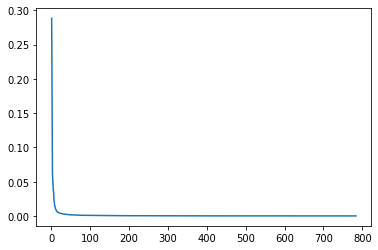

In [27]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.show()

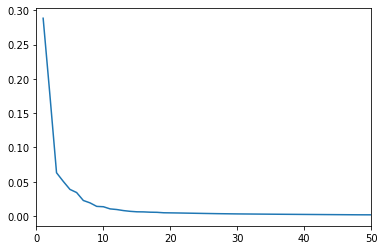

In [28]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,50)
plt.show()

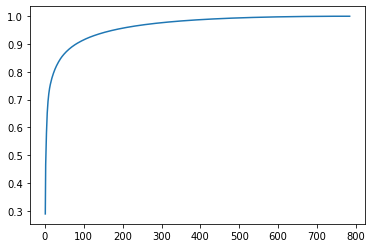

In [29]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)
plt.plot(range(1,785),cumulative)
plt.show()

In [35]:
np.where(np.array(cumulative)>0.85)[0][0] #기준:85% 이상을 설명할 수 있는 개수;41개

41

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


-XGBoost 활용

In [40]:
#pca를 통한 특징 추출 과정에서는 y라벨을 사용하지X(unsupervised)
#성능 확인 과정에서 y라벨이 사용됨
pca=PCA(n_components=42)
X_train_PCA=pca.fit_transform(X_train) #train은 fit + transform
X_test_PCA=pca.transform(X_test)       #test는 transform
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (5000, 784)
After PCA: (5000, 42)


In [36]:
#차원축소 이전
from xgboost import XGBClassifier
start=time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy: 0.9578
test accuracy: 0.85125
115.9559sec


In [41]:
#차원축소 이후
start=time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy: 0.927
test accuracy: 0.8225833333333333
16.2232sec


accuracy는 10^-2 단위로 아주 미세하게 떨어졌으나,
학습 시간은 10배 정도 차이나게 줄어듦.

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

0.6468sec


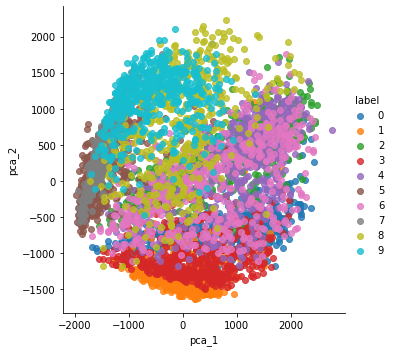

In [39]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

LDA: 데이터의 클래스를 잘 구분하도록 하는 특징을 뽑아냄
따라서, 숫자의 클래스를 구분하는 해당 task에 적합할 것으로 예상됨.

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2.1080sec


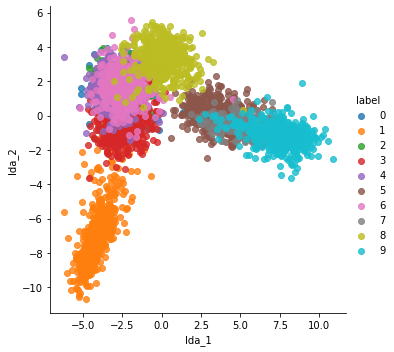

In [42]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

kPCA; 저차원에서 하나의 hyperplane으로 데이터가 분류되지 않는 상황일 수도 있으니 kPCA를 통해 고차원에서 PCA를 해본다.

10.3305sec


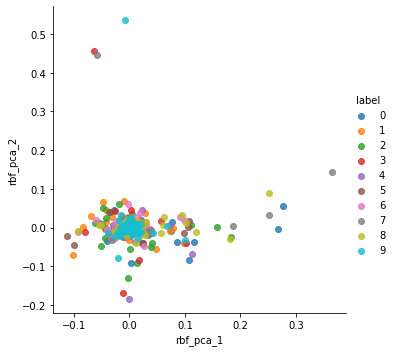

In [43]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

34.8471sec


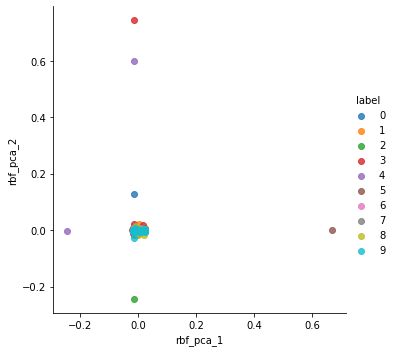

In [46]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 10, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

n_components를 늘렸을 때 데이터의 퍼짐 정도에 대해서는 개선이 이루어졌으나, 서로 다른 label을 가진 데이터 간의 구분이 어려워진다.

10.6336sec


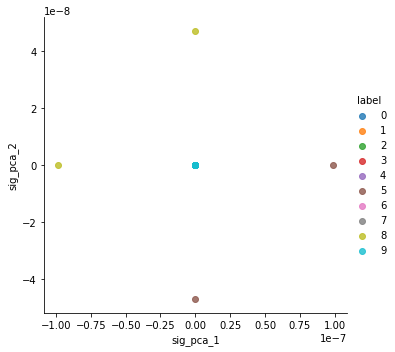

In [44]:
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

28.3668sec


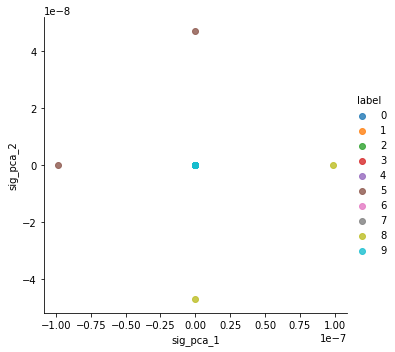

In [49]:
start=time.time()
sig_pca = KernelPCA(n_components = 10, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

주성분 개수가 문제가 아닌듯하다....

ISOMAP; 차원이 높아 초평면으로 데이터를 구분할 수 있는지 여부를 시각화로 확인할 수 없으니, 지오데식 거리를 잘 반영할 수 있는 ISOMAP도 사용해서 확인해본다.

21.5672sec


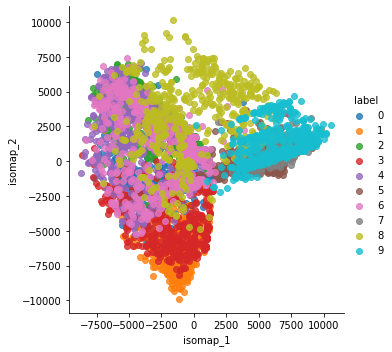

In [45]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4)         
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

21.2253sec


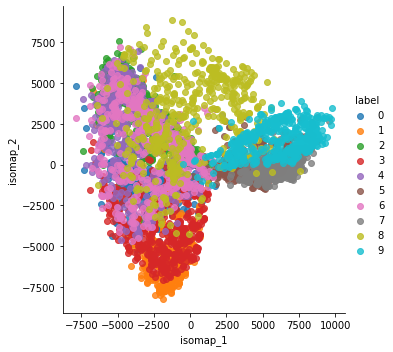

In [50]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=7,n_components=2,n_jobs=4)         
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

고려해야할 이웃한 개수를 7개로 늘렸는데 별 차이가 없는 것으로 보아 굳이 늘리지 않는게 좋을 것 같다. 특이한 점은 시간이 오히려 줄었다는..? 것이다...왜지..?

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

- (A) LDA가 시각화를 하였을 때, 데이터 구분이 쉬웠다. 이 문제가 classification에 대한 문제이기 때문에, 이에 특화된 LDA가 가장 좋은잘 시각화해준 것으로 추정된다. 또한 kPCA는 (충격적일 정도로) 구분이 안되는데, 이는 오히려 고차원으로 보냈을 때 초평면으로 잘라내기 어려운 상황, 또는 차원의 저주에 의해 발생한 문제라고 추정된다.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

- (A)4번과 6번이 가장 잘 구분이 안되었다. 이는 같은 셔츠이기 때문에 형태가 비슷하여 그런 것으로 추정된다.

수고하셨습니다~